In [27]:
'''this script is a sanity check the sinc_conv module is correct
and that it is consistent with my makefilter function'''


# Author: Jenny Sun
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import math
import matplotlib.pyplot as plt
from numpy.fft import fft


torch.manual_seed(2022)
np.random.seed(2022)
# random.seed(2021)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def flip(x, dim):
    xsize = x.size()
    dim = x.dim() + dim if dim < 0 else dim
    x = x.contiguous()
    x = x.view(-1, *xsize[dim:])
    x = x.view(x.size(0), x.size(1), -1)[:, getattr(torch.arange(x.size(1)-1,
                      -1, -1), ('cpu','cuda')[x.is_cuda])().long(), :]   # flip left and right
    return x.view(xsize)

def sinc(band,t_right):

    y_right= torch.sin(2*math.pi*band*t_right)/(2*math.pi*band*t_right).cuda()
    y_left= flip(y_right,0)
    y=torch.cat([y_left.cuda(),Variable(torch.ones(1)).cuda(),y_right.cuda()])

    return y

In [60]:
class sinc_conv(nn.Module):
    ''''''

    def __init__(self, N_filt, Filt_dim, fs):
        super(sinc_conv, self).__init__()


        low_freq = 0
        high_freq= 30
        freq_init = np.random.uniform(low_freq,high_freq, N_filt)
#         freq_init = np.arange(0,30,int(30/N_filt))

        b1 = freq_init
        b2 = np.zeros_like(b1) + 2

        self.freq_scale = fs * 1.0
        self.filt_b1 = nn.Parameter(torch.from_numpy(b1 / self.freq_scale))
        self.filt_band = nn.Parameter(torch.from_numpy(b2 / self.freq_scale))

        self.N_filt = N_filt
        self.Filt_dim = Filt_dim
        self.fs = fs
        self.cutoff = self.fs/2

    def forward(self, x):
        filters = Variable(torch.zeros((self.N_filt, self.Filt_dim)))
        N = self.Filt_dim
        t_right = Variable(torch.linspace(1, (N - 1) / 2, steps=int((N - 1) / 2)) / self.fs).cuda()
        min_freq = 1.0
        min_band = 2.0;
        filt_beg_freq = torch.abs(self.filt_b1) +  min_freq / self.freq_scale
        filt_end_freq = torch.clamp(filt_beg_freq + (torch.abs(self.filt_band) + min_band / self.freq_scale), \
                                    int(min_freq+min_band)/self.freq_scale, (self.cutoff)/self.freq_scale)
        n = torch.linspace(0, N, steps=N)

        # Filter window (hamming)
        window = 0.54 - 0.46 * torch.cos(2 * math.pi * n / N);
        window = Variable(window.float()).cuda()

        for i in range(self.N_filt):
            low_pass1 = 2 * filt_beg_freq[i].float() * sinc(filt_beg_freq[i].float() * self.freq_scale, t_right.cuda())
            low_pass2 = 2 * filt_end_freq[i].float() * sinc(filt_end_freq[i].float() * self.freq_scale, t_right.cuda())
            band_pass = (low_pass2 - low_pass1)

            band_pass = band_pass / torch.max(band_pass)   #normalize to one

            filters[i, :] = band_pass * window
        batch_n = x.shape[0]
        x = x.cuda()
        # return filters
        out = F.conv2d(x.view(batch_n,1,x.shape[1],x.shape[-1]), filters.view(self.N_filt, 1, 1,self.Filt_dim).cuda())

        return out, filters,(filt_beg_freq, filt_end_freq)

In [61]:
# make a signal with different frequencies

def makeSincFilters(filt_begin, filt_end, sr = 1000, N = 1001, windowFunc =True):
    '''filt_begin takes frequency, not fraction of sampling rate
    therefore, sr and N doesn't really matter
    N must be odd number'''

    filt_begin = filt_begin /sr
    filt_end = filt_end / sr
    n = np.arange(N)
    numFilters = len(filt_begin)
    myfilters = np.zeros((numFilters,N))
    for numf in range(numFilters):
        fc0 = filt_begin[numf]
        h0 = 2 * fc0 * np.sinc((2 * fc0 * (n - (N - 1) / 2)))
        fc1 = filt_end[numf]
        h1 = 2 * fc1 * np.sinc((2 * fc1 * (n - (N - 1) / 2)))
        band = h1 - h0
        band = band / np.max(band)
        if windowFunc:
            band = band * (0.54 - 0.46 * np.cos(2 * math.pi * n / N))
        myfilters[numf, :] = band
    return myfilters

def plotFFT(x,dur=1, sr=1000, xlim = 50):
    L = sr * dur
    T = 1.0 / sr  # sampling period
    # fft the data
    Y = fft(x)
    # compute the two-sided spectrum P2
    P2 = np.abs(Y / L)  # power spectrum
    # then compute the single-sided spectrum P1 based on P2a and the real-valued signal length L
    P1 = P2[0:int(L / 2)]  # 0 Hz included
    P1[1:] = 2 * P1[1:]
    f = sr * np.arange(0, L / 2) / L
    # ax.plot(f, P1)
    # ax.set_xlim(0, xlim)
    return f, P1

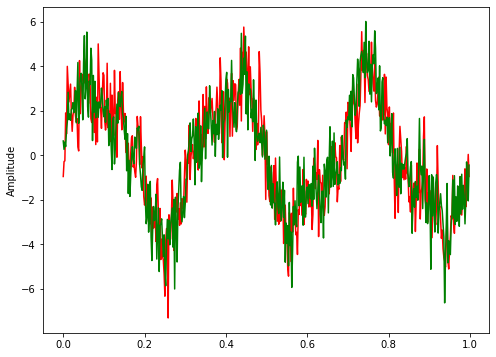

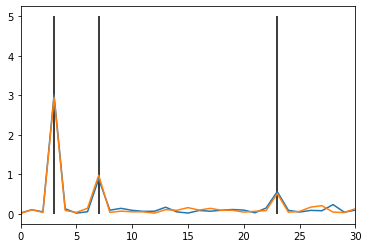

In [62]:
# first make a signal with different freq components and FFT

####### test FFT algorithm ##########
# sampling rate
sr = 500

# sampling interval
dur = 1     # 2 s
L = sr *dur   # signal length
T = 1.0/sr # sampling period
t = np.arange(0,L) * T  # time vector

# make the signals
x= []
freq0 = 3
x = 3*np.sin(2*np.pi*freq0*t)

freq1 = 7
x += np.sin(2*np.pi*freq1*t)

freq2 = 23
x += 0.5* np.sin(2*np.pi*freq2*t)

# add some noise
noise0 = np.random.normal(0,1,len(t))
noise1 =  np.random.normal(0,1,len(t))
x0 = x+ noise0
x1 = x + noise1
X = np.vstack((x0,x1))

plt.figure(figsize = (8, 6))
plt.plot(t, x0, 'r')
plt.plot(t, x1, 'g')

plt.ylabel('Amplitude')
plt.show()


# # fft the data
Y = fft(X,axis=1)
# # compute the two-sided spectrum P2
P2 = np.abs(Y/L) #power spectrum

# # then compute the single-sided spectrum P1 based on P2a and the real-valued signal length L
P1 = P2[:,0:int(L/2)]  # 0 Hz included
P1[:,1:] = 2 * P1[:,1:]

# define the frequency domain f
f = sr * np.arange(0, L/2) /L

plt.figure()
plt.plot(f, P1[0,:])
plt.plot(f, P1[1,:])
plt.xlim(0,30)
plt.vlines(freq0, 0,5 ,'k')
plt.vlines(freq1, 0,5,'k')
plt.vlines(freq2, 0,5,'k')
plt.show()

In [82]:
# using sinConvo to get some filters
sinc_nn = sinc_conv(10, 131, sr).cuda()
signal = torch.tensor(X.reshape(1,2,500).astype('float32')).cuda()
y, filters, Fs = sinc_nn(signal)
y = y.cpu().detach().numpy().squeeze()
filters  = filters.cpu().detach().numpy()
beg = Fs[0].cpu().detach().numpy() * sr
end = Fs[1].cpu().detach().numpy() *sr

19.284060242072506 23.284060242072506


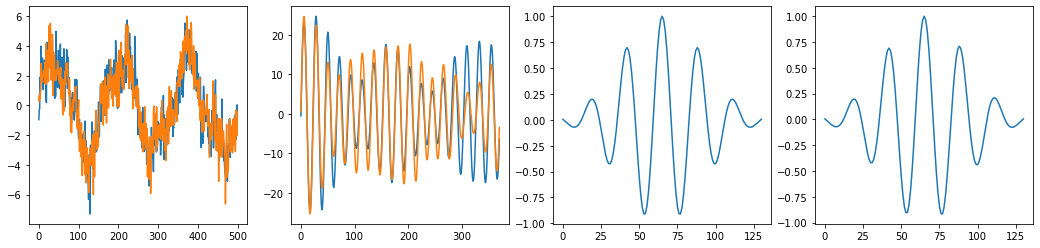

In [83]:
# let's plo the corresponding filters

filt = 3
fig, ax = plt.subplots(1,4, figsize = (18,4))
ax[0].plot(X.T)
ax[1].plot(y[filt,:,:].T)
ax[2].plot(filters[filt,:])

# use my algo to make sinc filters

myfilters = makeSincFilters(beg, end, sr = 500, N = 131, windowFunc =True)
ax[3].plot(myfilters[filt,:])
print(beg[filt],end[filt])

19.284060242072506 23.284060242072506


(0.0, 30.0)

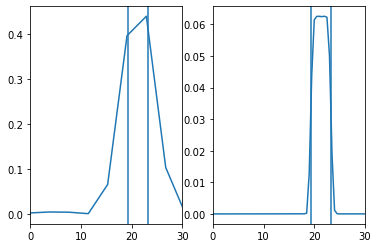

In [84]:
# check fft of the signals
# fft the sinc_conv filter to recover the freq
myf  = fft(filters[filt,:])
L = len(myf)
P2 = np.abs(myf/L) #power spectrum

# # then compute the single-sided spectrum P1 based on P2a and the real-valued signal length L
P1 = P2[0:int(L/2)+1]  # 0 Hz included
P1[1:] = 2 * P1[1:]

# define the frequency domain f
fig,ax = plt.subplots(1,2)
f = sr * np.arange(0,L/2) /L
ax[0].plot(f,P1)
ax[0].set_xlim(0,30)
ax[0].axvline(beg[filt], 0,1)
ax[0].axvline(end[filt], 0,1)

myfilters = makeSincFilters(beg, end, sr = 500, N = 1001, windowFunc =True)
print(beg[filt], end[filt])
f, p = plotFFT(myfilters[filt],dur = 2)
ax[1].plot(f,p)
ax[1].axvline(beg[filt], 0,1)
ax[1].axvline(end[filt], 0,1)
plt.xlim(0,30)

In [85]:
sinc_nn = sinc_conv(10, 131, sr).cuda()
signal = torch.tensor(X.reshape(1,2,500).astype('float32')).cuda()
y, filters, Fs = sinc_nn(signal)

In [86]:
end = Fs[0]

In [87]:
Y = end *5
J = Y+ 5

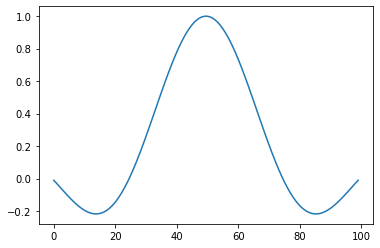

In [79]:
fc0=10/sr
N=100
n=np.arange(N)
signal1 = np.sinc((2 * fc0 * (n - (N - 1) / 2)))
plt.plot(signal1)

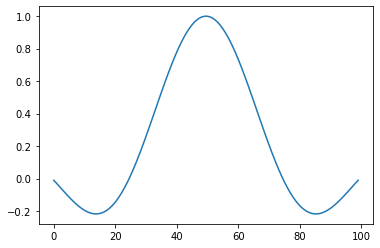

In [70]:
signal2 = np.sinc((2 * fc0*sr * (n - (N - 1) / 2)/sr))
plt.plot(signal2)